In [1]:
%%html
<link rel="stylesheet" type="text/css" href="rise.css" />

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = [8, 6]

# Convolutional Neural Network (CNN)

In [3]:
import torch
from torch import nn

In [4]:
from IPython.display import Image
Image(url='https://miro.medium.com/max/790/1*1okwhewf5KCtIPaFib4XaA.gif')

# Mouse V1 activity in response to gratings of varying orientation

Mouse V1 data from Stringer et al. (2019)
https://www.biorxiv.org/content/10.1101/679324v2.abstract

![](images/grating-mouse.png)

These data comprise time-averaged responses of ~20,000 neurons to ~4,000 stimulus gratings of different orientations from 0-360 degrees, recorded through Calcium imaging. The responses have been normalized by spontaneous levels of activity and then z-scored over stimuli, so expect negative numbers. They have also been binned and averaged to each degree of orientation.

Example from [Neuromatch Academy](https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial1.html)

Calcium imaging measures of activity from 23,589 neurons in V1 in response to vieweing a grating pattern rotated from 0-360 degrees.

![](images/grating-orientations.png)

In [5]:
neural_responses = np.load('data/neural_responses.npy')
grating_orientations = np.load('data/grating_orientations.npy')

neural_responses.shape, grating_orientations.shape

((360, 23589), (360,))

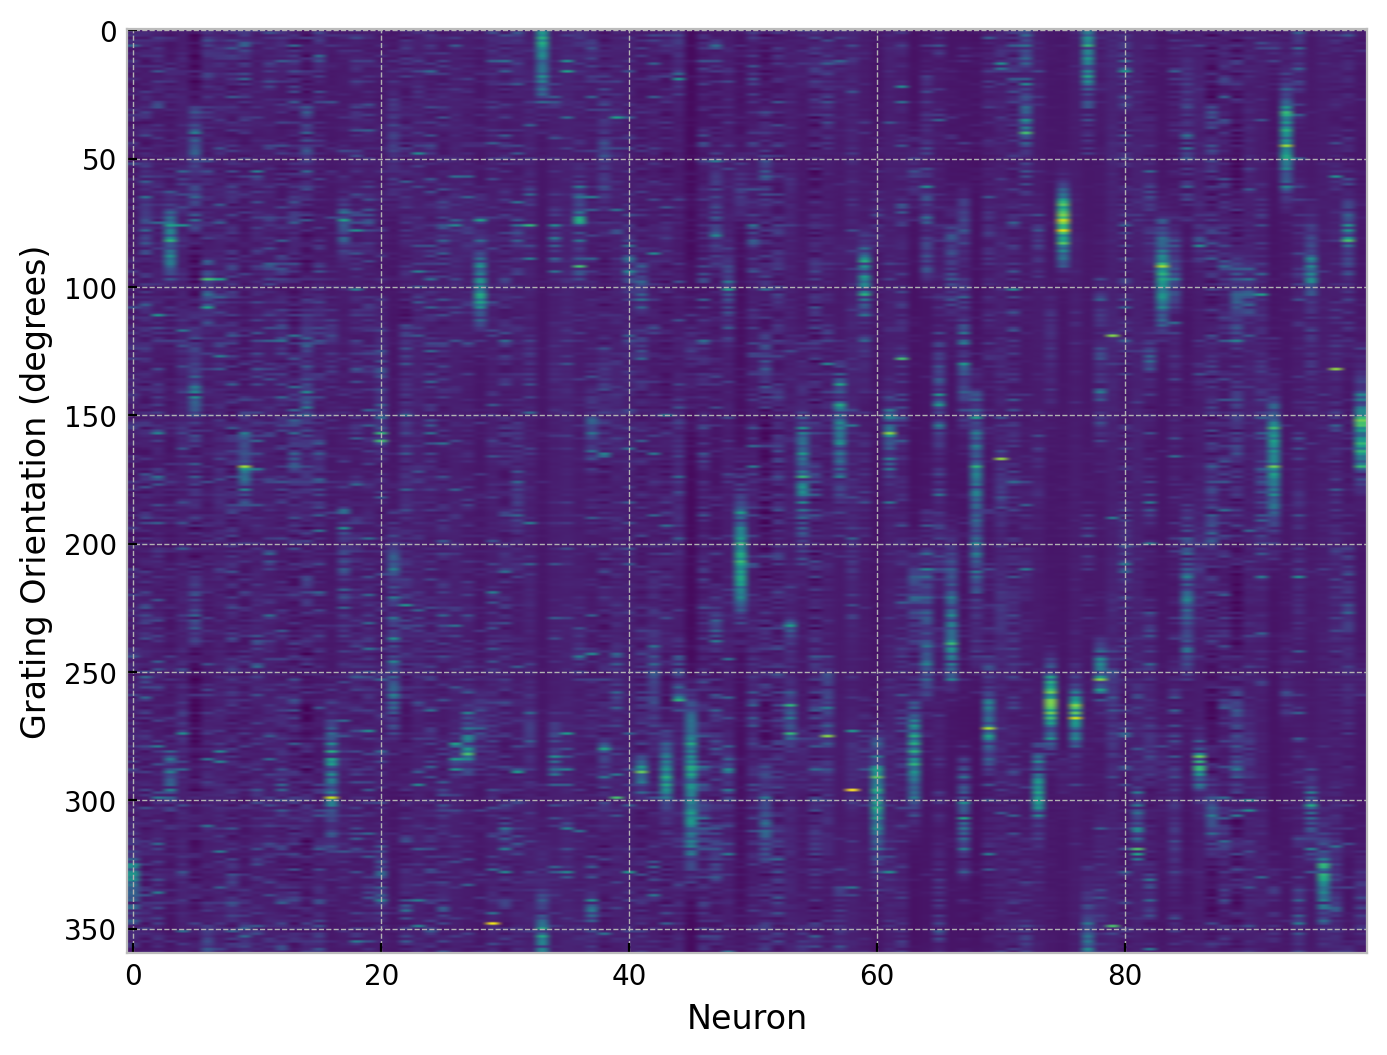

In [6]:
plt.imshow(neural_responses[:,:100], aspect='auto')
plt.xlabel('Neuron')
plt.ylabel('Grating Orientation (degrees)');

Instead of predicting the grating orientation based on the mouse's neural activity, let's see if we can determine the grating orientation based on the grating images themselves.

First, let's make some images of gratings.

In [7]:
# adapted from https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.html#helper-functions
def make_grating(angle, sf=1 / 28, res=0.1, patch=False):
    """Generate oriented grating stimulus

    Args:
    angle (float): orientation of grating (angle from vertical), in degrees
    sf (float): controls spatial frequency of the grating
    res (float): resolution of image. Smaller values will make the image
      smaller in terms of pixels. res=1.0 corresponds to 640 x 480 pixels.
    patch (boolean): set to True to make the grating a localized
      patch on the left side of the image. If False, then the
      grating occupies the full image.

    Returns:
    torch.Tensor: (res * 480) x (res * 640) pixel oriented grating image

    """

    angle = np.deg2rad(angle)  # transform to radians

    wpix, hpix = 640, 480  # width and height of image in pixels for res=1.0

    xx, yy = np.meshgrid(sf * np.arange(0, wpix * res) / res, sf * np.arange(0, hpix * res) / res)

    if patch:
        gratings = np.cos(xx * np.cos(angle + .1) + yy * np.sin(angle + .1))  # phase shift to make it better fit within patch
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1
        xcent = gratings.shape[1] * .75
        ycent = gratings.shape[0] / 2
        xxc, yyc = np.meshgrid(np.arange(0, gratings.shape[1]), np.arange(0, gratings.shape[0]))
        icirc = ((xxc - xcent) ** 2 + (yyc - ycent) ** 2) ** 0.5 < wpix / 3 / 2 * res
        gratings[~icirc] = 0.5
    else:
        gratings = np.cos(xx * np.cos(angle) + yy * np.sin(angle))
        gratings[gratings < 0] = 0
        gratings[gratings > 0] = 1

    gratings -= 0.5

    # Return torch tensor
    return torch.tensor(gratings, dtype=torch.float32)

For visualization, let's just create a handful of gratings at a few angles and then view them.

In [8]:
orientations = [0, 22.5, 45, 67.5, 90]

stimuli = torch.zeros((len(orientations), 1, 48, 64), dtype=torch.float32)

for i, ori in enumerate(orientations):
    stimuli[i,0,:,:] = make_grating(ori)

stimuli.shape

torch.Size([5, 1, 48, 64])

Visualize our handful of sample grating images...

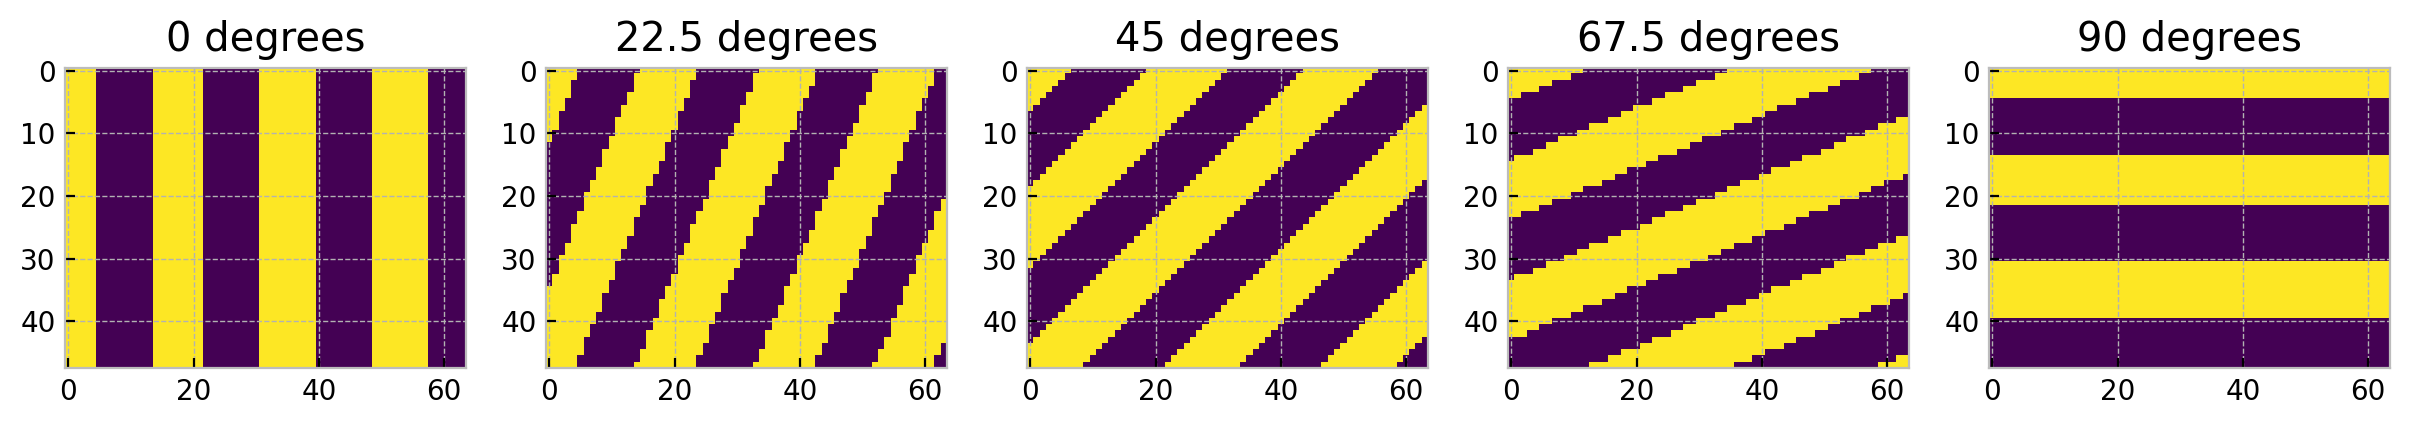

In [9]:
plt.figure(figsize=[15,5])
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(stimuli[i,0,:,:])
    plt.title(f'{orientations[i]} degrees')

Now that you get the idea, let's make a grating for each of 360 degree rotations.

In [10]:
orientations = np.arange(-90, 90)

stimuli = torch.zeros((len(orientations), 1, 48, 64), dtype=torch.float32)

for i, ori in enumerate(orientations):
    stimuli[i,0,:,:] = make_grating(ori)

stimuli.shape

torch.Size([180, 1, 48, 64])

We're going to implement a convolutional neural network to determine the grating left/right tilt.

We will use convolution kernels that have some relation to receptive fields in visual cortex.

Le't make 6 filters mimicking various receptive fields.

In [11]:
# adapted from https://compneuro.neuromatch.io/tutorials/W2D1_DeepLearning/student/W2D1_Tutorial2.html#helper-functions
def make_filters(out_channels=6, K=7):
    """ make example filters, some center-surround and gabors
    Returns:
      filters: out_channels x K x K
    """
    grid = np.linspace(-K/2, K/2, K).astype(np.float32)
    xx,yy = np.meshgrid(grid, grid, indexing='ij')

    # create center-surround filters
    sigma = 1.1
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*sigma**2))
    wide_gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*2)**2))
    center_surround = gaussian - 0.5 * wide_gaussian

    # create gabor filters
    thetas = np.linspace(0, 180, out_channels-2+1)[:-1] * np.pi/180
    gabors = np.zeros((len(thetas), K, K), np.float32)
    lam = 10
    phi = np.pi/2
    gaussian = np.exp(-(xx**2 + yy**2)**0.5/(2*(sigma*0.4)**2))
    for i,theta in enumerate(thetas):
        x = xx*np.cos(theta) + yy*np.sin(theta)
        gabors[i] = gaussian * np.cos(2*np.pi*x/lam + phi)

    filters = np.concatenate((center_surround[np.newaxis,:,:],
                            -1*center_surround[np.newaxis,:,:],
                            gabors),
                           axis=0)
    filters /= np.abs(filters).max(axis=(1,2))[:,np.newaxis,np.newaxis]
    filters -= filters.mean(axis=(1,2))[:,np.newaxis,np.newaxis]
    # convert to torch
    filters = torch.tensor(filters, dtype=torch.float32)
    # add channel axis
    filters = filters.unsqueeze(1)

    return filters

Make the filter kernels.

In [12]:
filters = make_filters(out_channels=6, K=7)

filters.shape

torch.Size([6, 1, 7, 7])

Visualize the filter kernels.

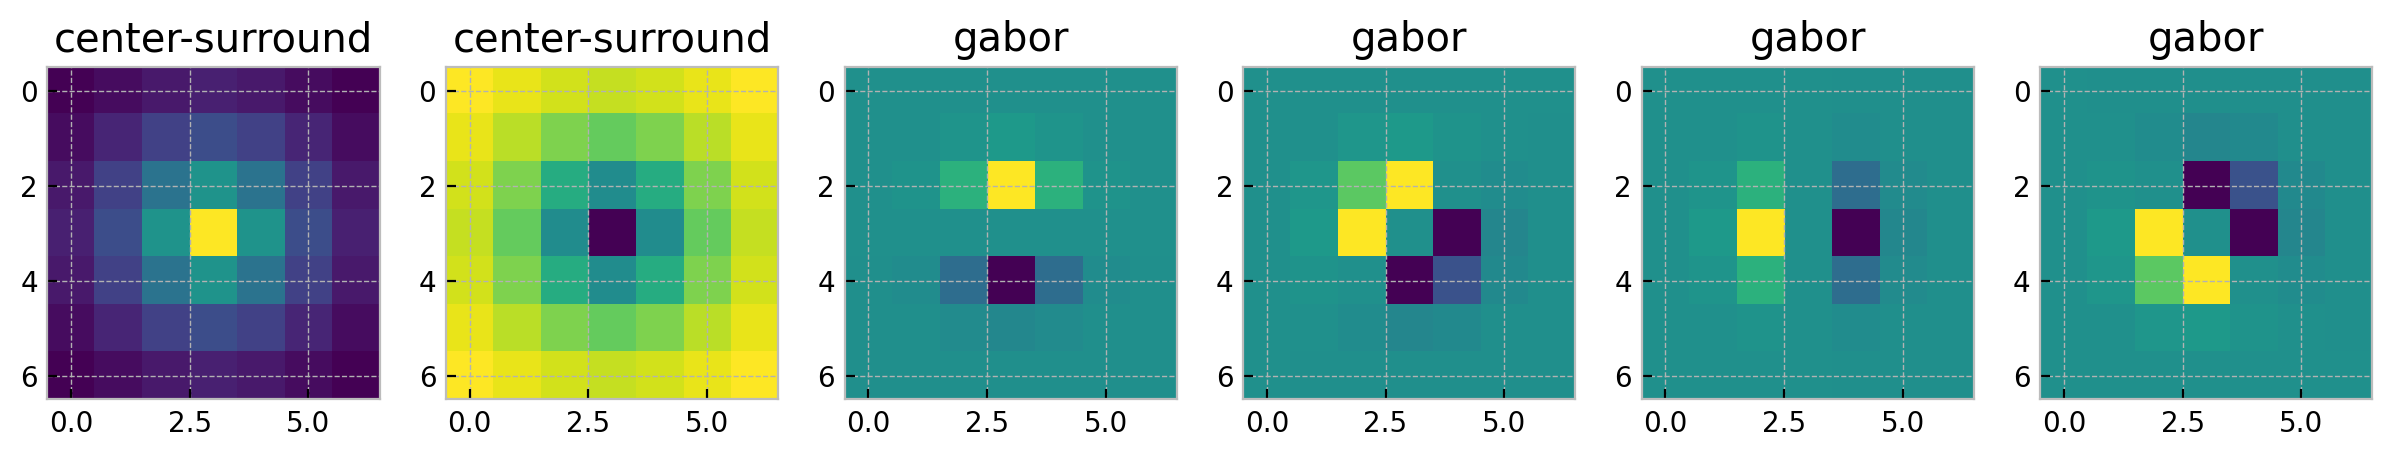

In [13]:
plt.figure(figsize=[15,4])
for i in range(6):
    plt.subplot(1, 6, i+1)
    plt.imshow(filters[i,0,:,:])
    if i < 2:
        plt.title('center-surround')
    else:
        plt.title('gabor')

Now let's try a convolutional neural network something like this (we'll skip the pooling step and we'll only have two fully connected layers)...

![](images/conv-fc-net.png)

In [14]:
class GratingTiltNet(nn.Module):
    
    def __init__(self):
        nn.Module.__init__(self)
        
        # convolutional layer
        # add padding to ensure that each channel has same dimensionality as input
        self.conv = nn.Conv2d(1, 6, kernel_size=7, padding=3)
        
        # init convolutional kernels to center-surround and gabor filters
        self.conv.weight = nn.Parameter(filters)
        self.conv.bias = nn.Parameter(torch.zeros((6,), dtype=torch.float32))
        
        # fully connected layer with 10 neurons
        self.fc = nn.Linear(6 * 48 * 64, 10)
        
        # output layer with single neuron for predicting grating orientation angle
        self.out = nn.Linear(10, 1)

    def forward(self, images_in):
        # images_in:  n_stimuli x 1  x h x w
        # images_out: n_stimuli x 6 x h x w
        images_out = self.conv(images_in)
        
        # each row of X is the flattened output from the convolutional layer
        # for one stimulus image
        X = images_out.reshape(-1, 6 * 48 * 64)
        
        # length 10 output of fully connected layer
        X = torch.relu(self.fc(X))
        
        # network output for single value of grating orientation angle
        y = self.out(X)

        # convert y in [-inf, inf] to [-1, 1]
        y = torch.sin(y)
        
        return y

Initial untrained left vs. right tilt predictions.

In [15]:
net = GratingTiltNet()
prediction = net(stimuli)
prediction.shape

torch.Size([180, 1])

In [16]:
orientations = np.arange(-90, 90)
predicted_orientations = prediction.detach().numpy() * 90

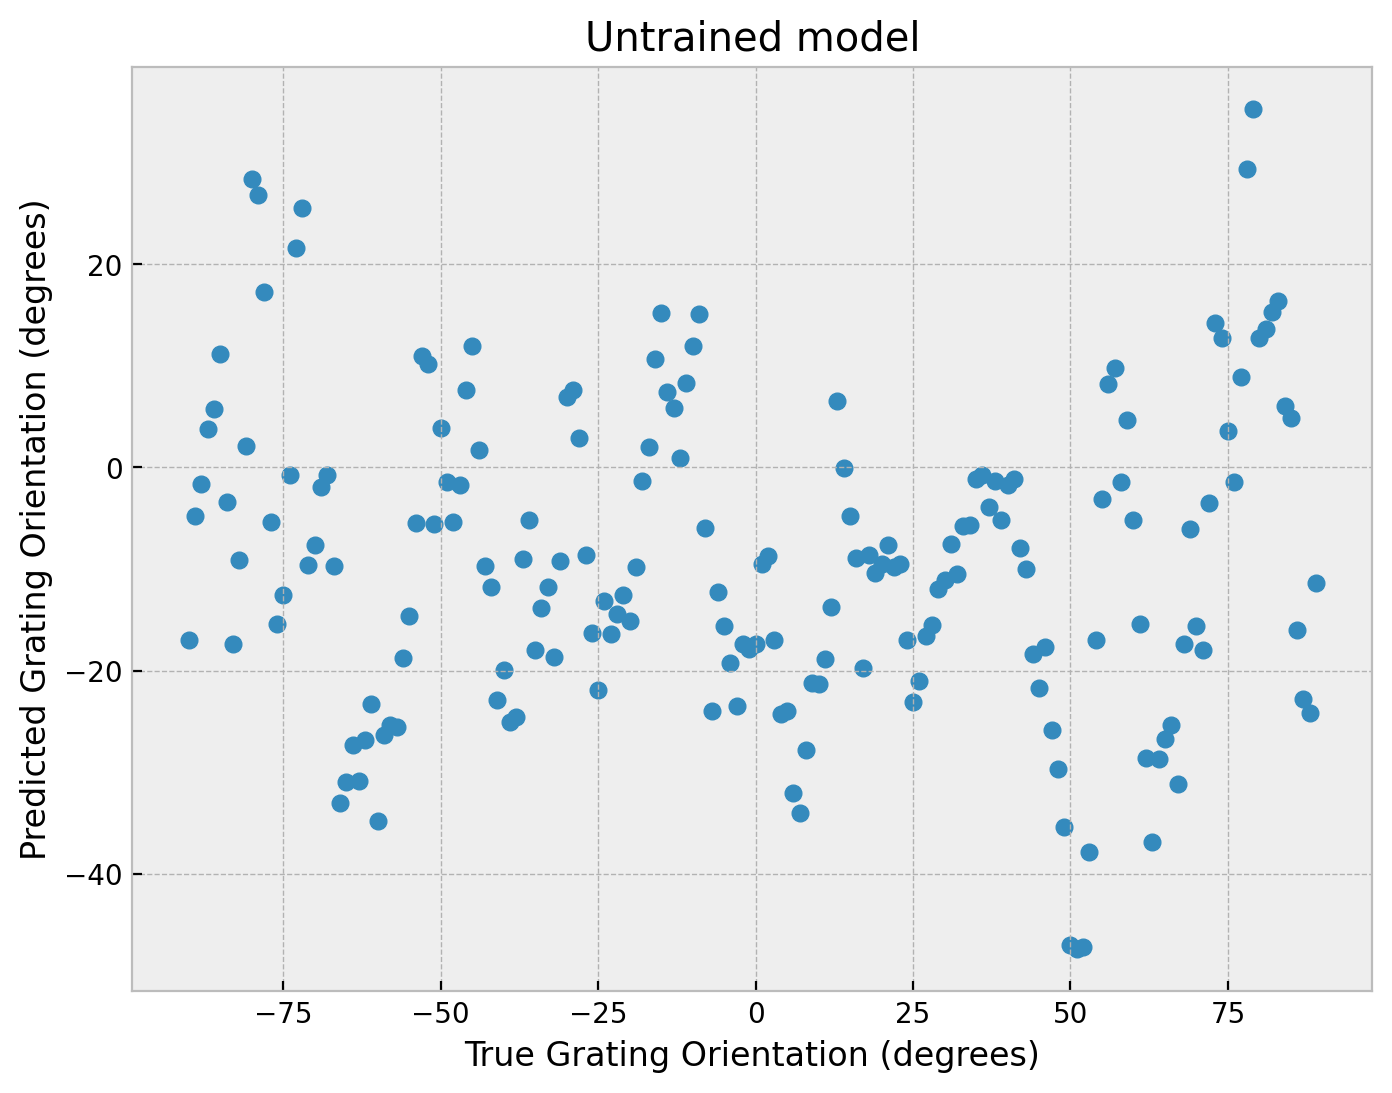

In [17]:
plt.scatter(orientations, predicted_orientations)
plt.xlabel('True Grating Orientation (degrees)')
plt.ylabel('Predicted Grating Orientation (degrees)')
plt.title('Untrained model');

Now let's train the model.

In [18]:
def train(X, y, model, loss_fn, optimizer):
    # Put the model into training mode.
    model.train()

    # Compute prediction error
    pred = model(X)
    loss = loss_fn(pred, y)

    # Backpropagation
    # Computes gradient of loss and updates model parameters
    # to reduce loss
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    # Return loss so we can keep track of it
    # .item() extracts float value from single-valued tensor
    return loss.item()

In [19]:
def test(X, y, model, loss_fn):
    # Put the model into evaluation mode.
    model.eval()

    # Do NOT compute unecessary gradients during evaluation.
    with torch.no_grad():
        pred = model(X)
        loss = loss_fn(pred, y)

    # Return loss so we can keep track of it
    # .item() extracts float value from single-valued tensor
    return loss.item()

Convert true output to range [0,1] as appropriate for sigmoidal output from network.

Split the data into training and testing sets.

In [20]:
from sklearn.model_selection import train_test_split

X = stimuli
y = torch.tensor(np.arange(-90, 90) / 90, dtype=torch.float32)  # in [-1, 1]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.4, random_state=3)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([108, 1, 48, 64]),
 torch.Size([72, 1, 48, 64]),
 torch.Size([108]),
 torch.Size([72]))

In [21]:
y_train = y_train.reshape([-1,1])
y_test = y_test.reshape([-1,1])

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([108, 1, 48, 64]),
 torch.Size([72, 1, 48, 64]),
 torch.Size([108, 1]),
 torch.Size([72, 1]))

In [22]:
model = GratingTiltNet()
loss_fn = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [23]:
epochs = 100
train_loss = []
test_loss = []

for t in range(epochs):
    loss = train(X_train, y_train, model, loss_fn, optimizer)
    train_loss.append(loss)
    
    loss = test(X_test, y_test, model, loss_fn)
    test_loss.append(loss)

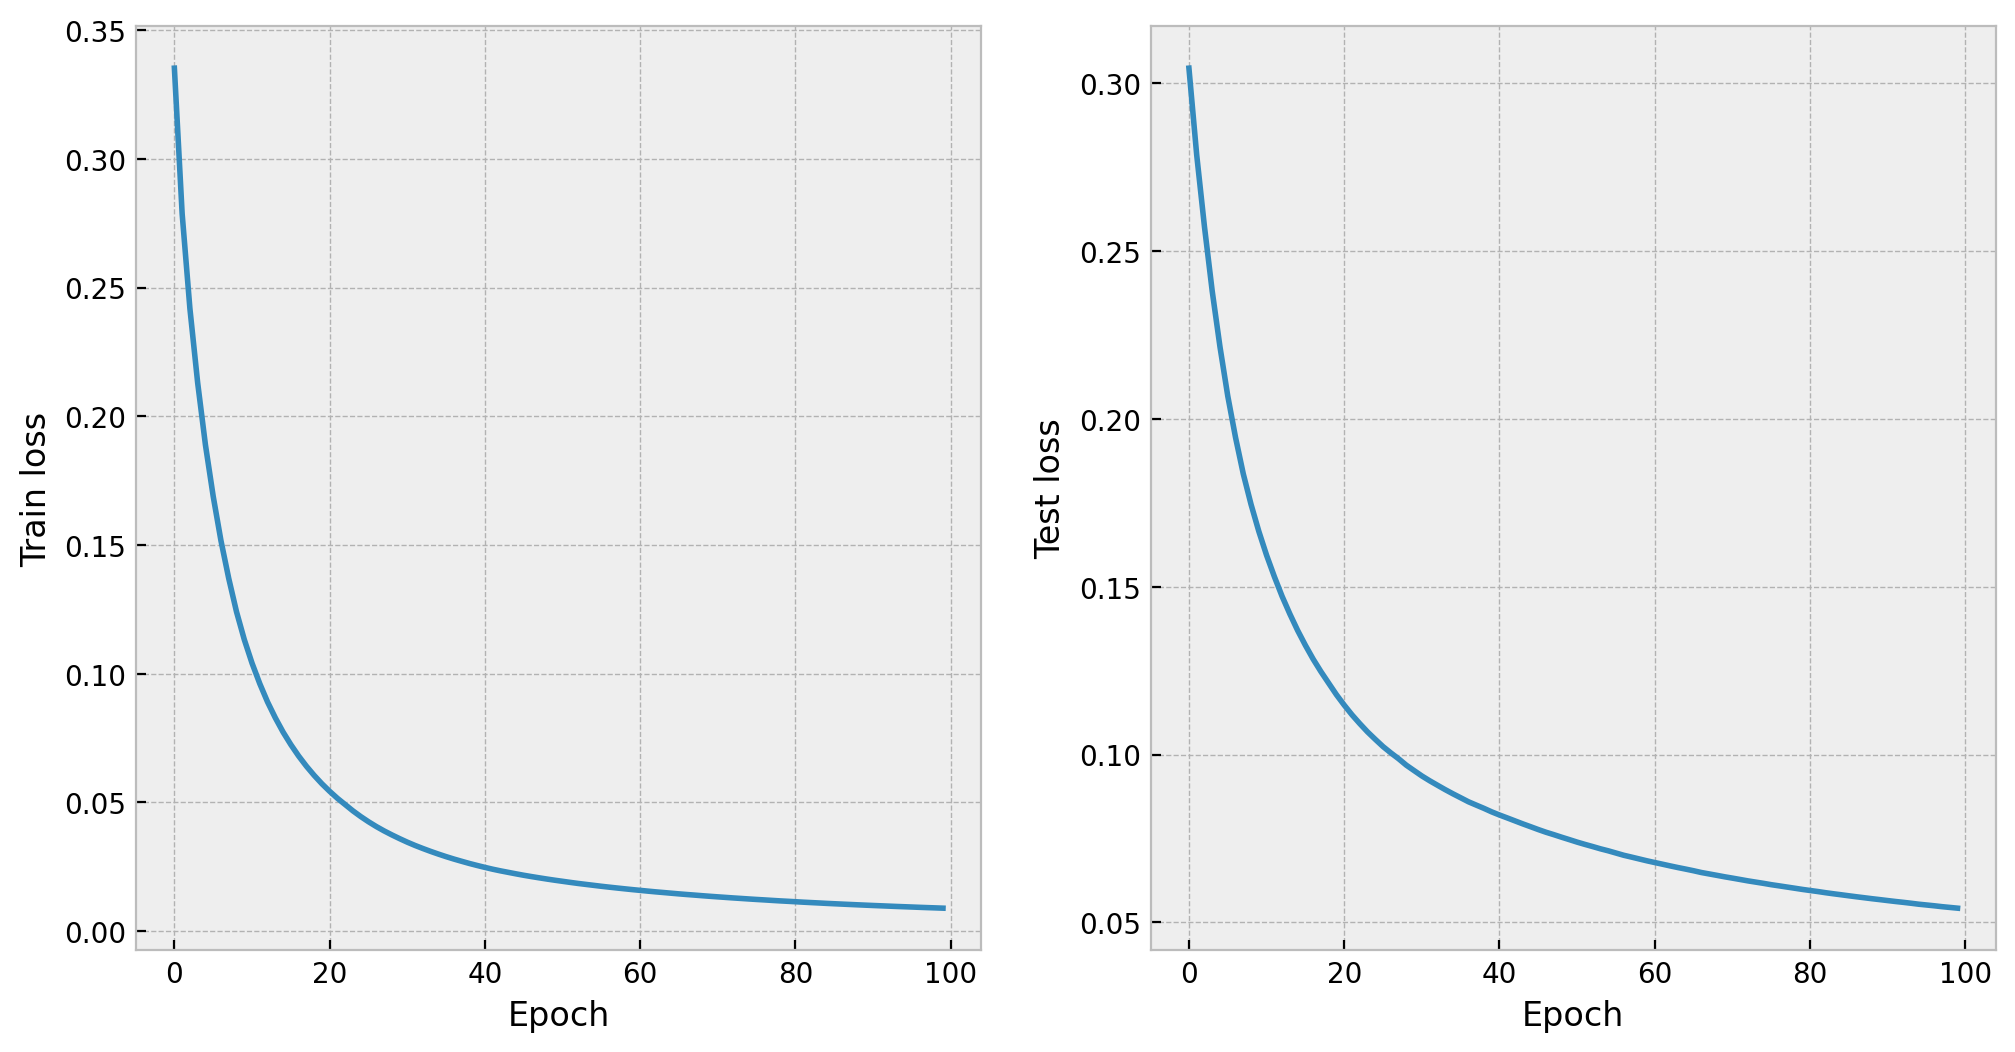

In [24]:
plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.subplot(1, 2, 2)
plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Test loss');

Keep training...

In [25]:
epochs = 300

for t in range(epochs):
    loss = train(X_train, y_train, model, loss_fn, optimizer)
    train_loss.append(loss)
    
    loss = test(X_test, y_test, model, loss_fn)
    test_loss.append(loss)

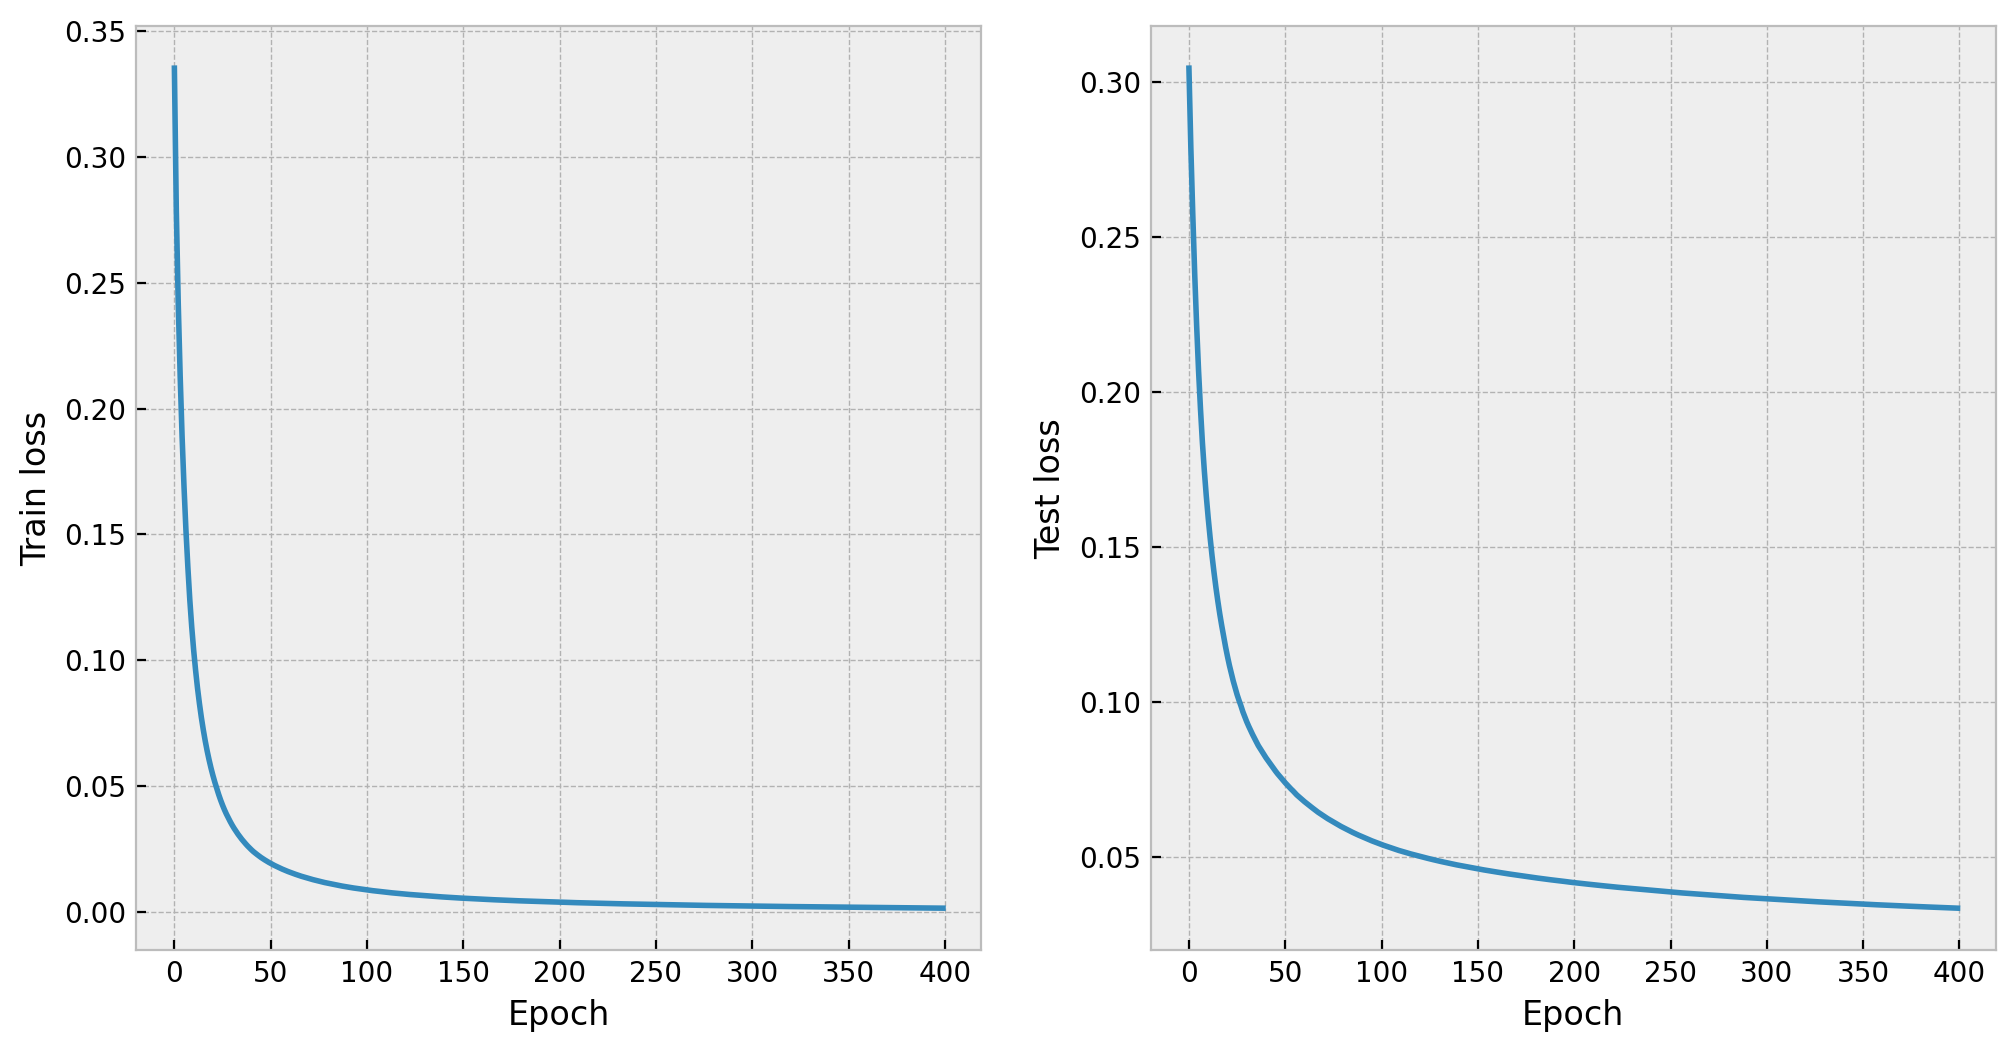

In [26]:
plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.subplot(1, 2, 2)
plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Test loss');

Keep training...

In [27]:
epochs = 600

for t in range(epochs):
    loss = train(X_train, y_train, model, loss_fn, optimizer)
    train_loss.append(loss)
    
    loss = test(X_test, y_test, model, loss_fn)
    test_loss.append(loss)

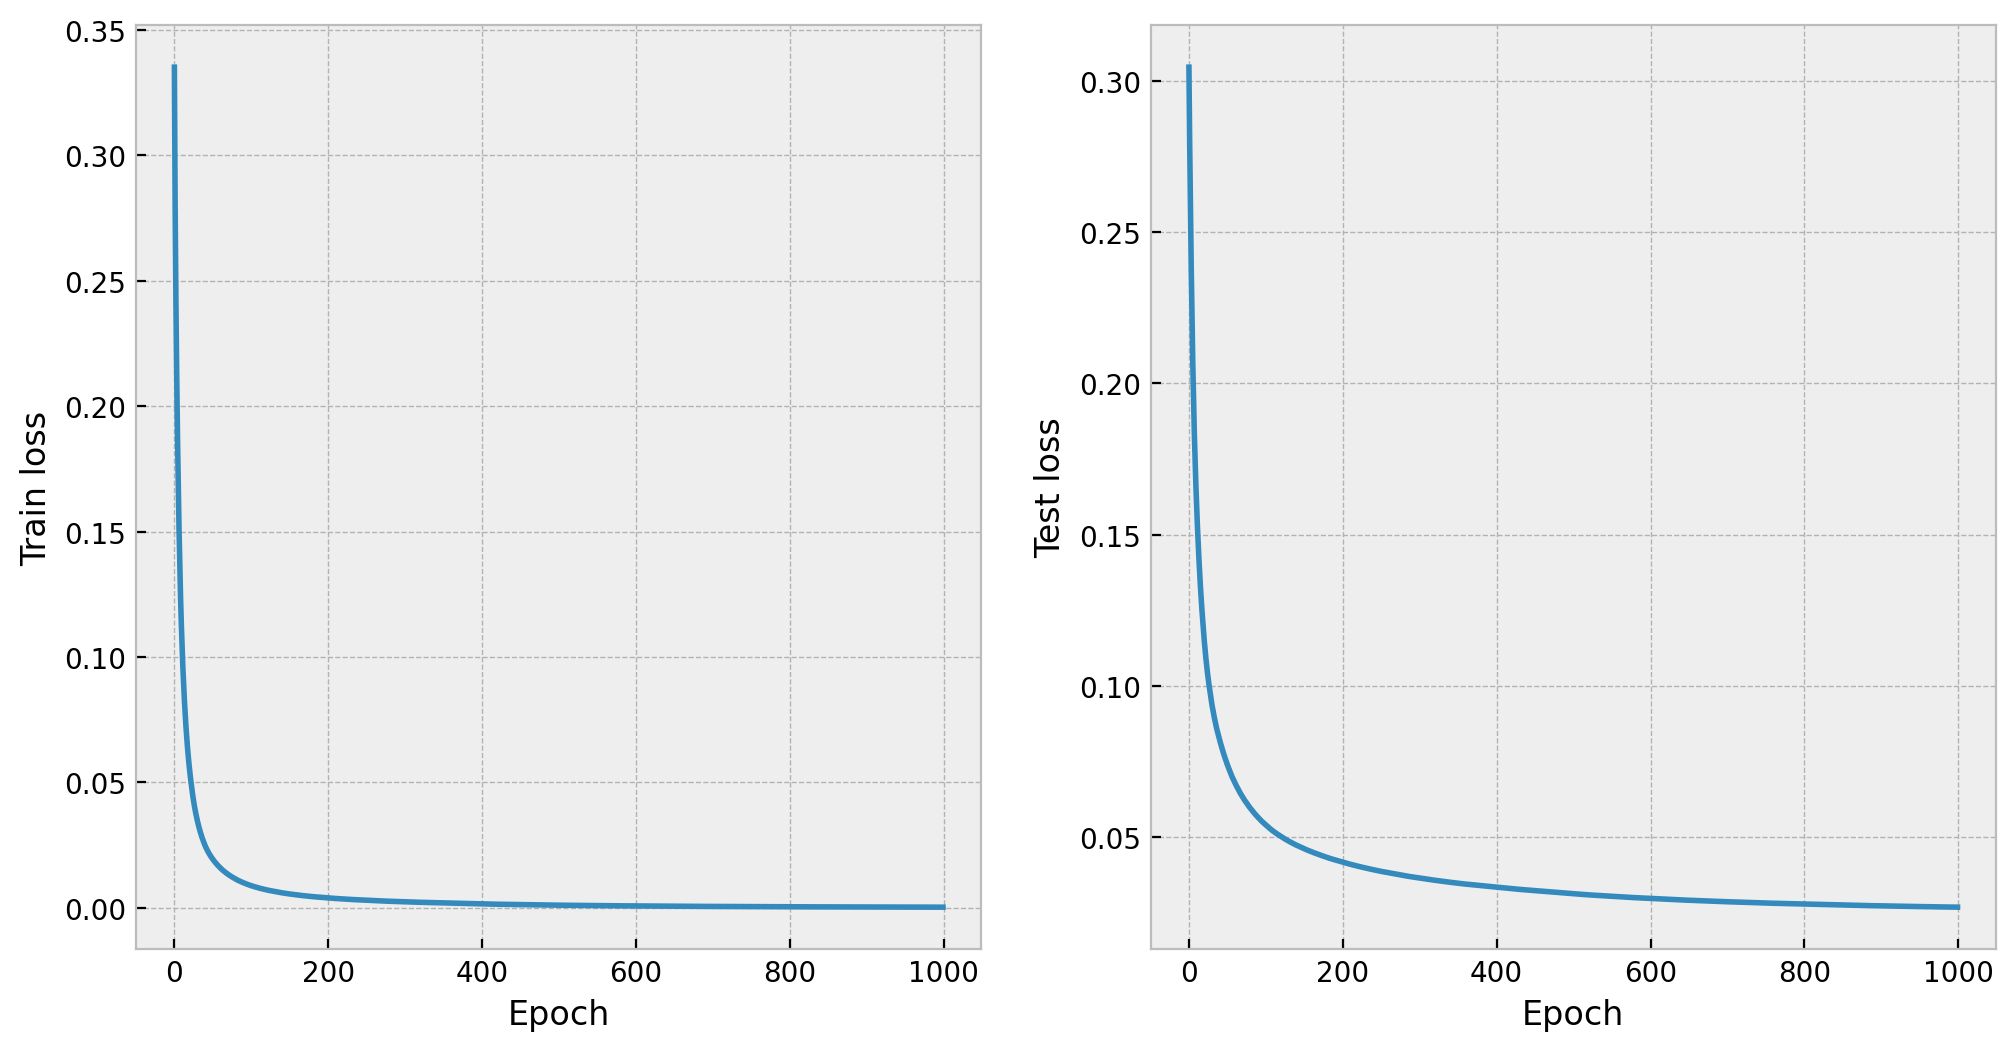

In [28]:
plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(train_loss)
plt.xlabel('Epoch')
plt.ylabel('Train loss')
plt.subplot(1, 2, 2)
plt.plot(test_loss)
plt.xlabel('Epoch')
plt.ylabel('Test loss');

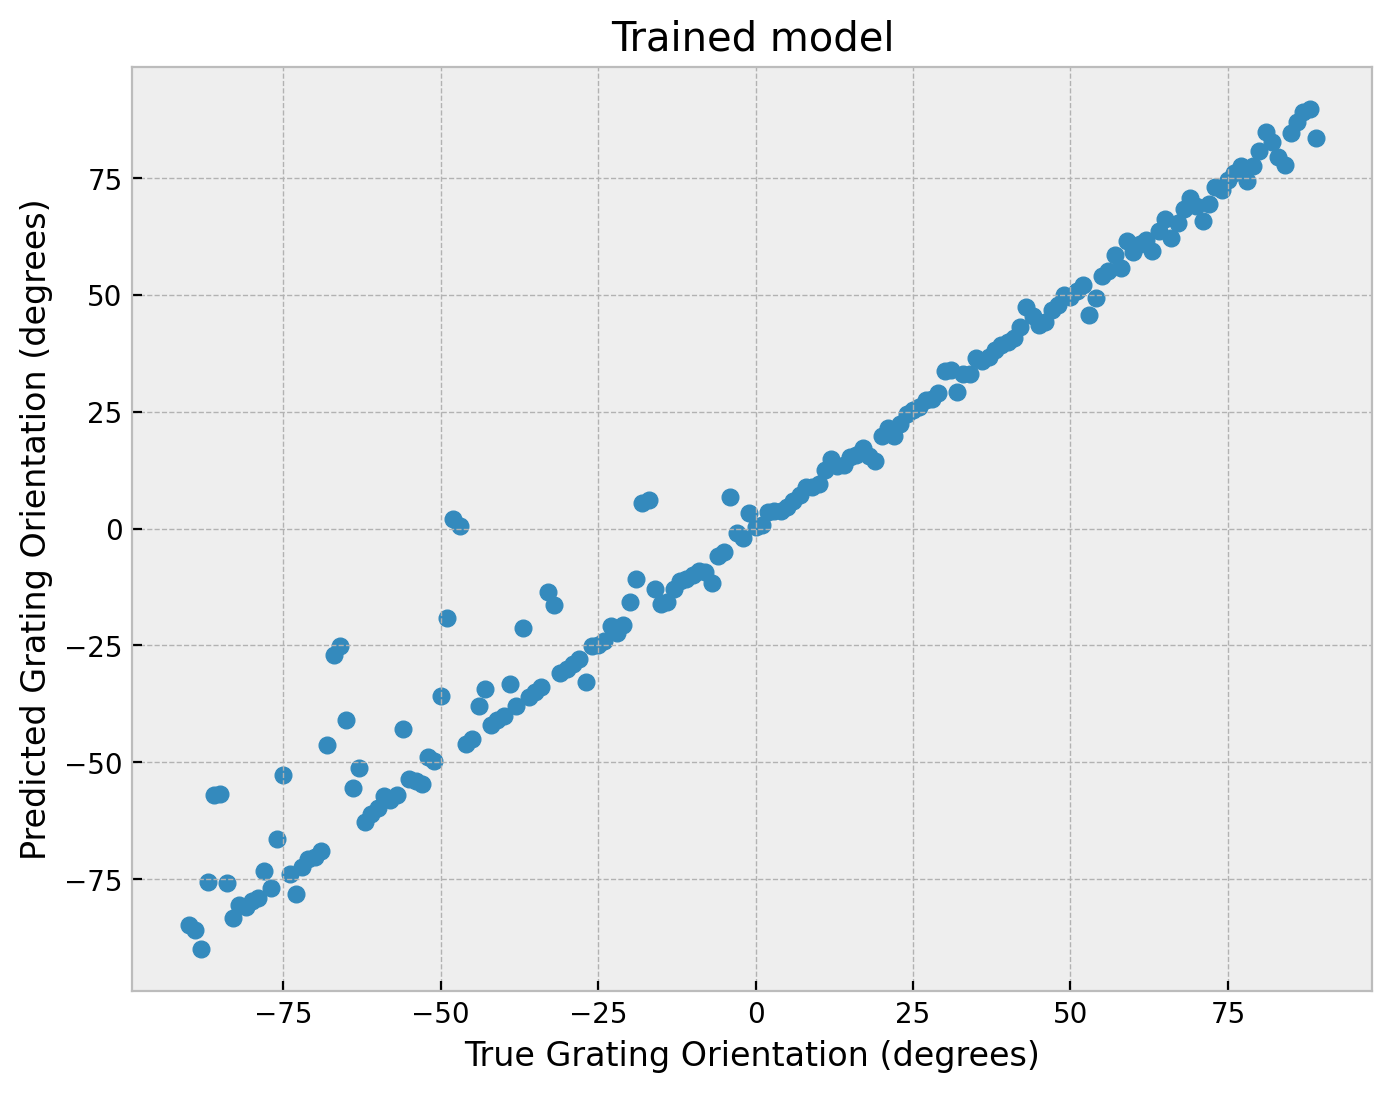

In [29]:
output = model(stimuli)
angles = output.detach().numpy() * 90

plt.scatter(range(-90, 90), angles)
plt.xlabel('True Grating Orientation (degrees)')
plt.ylabel('Predicted Grating Orientation (degrees)')
plt.title('Trained model');